In [196]:
# Importing libraries

import numpy as np
from numpy.lib import scimath
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
from scipy import signal
from scipy.fftpack import fft, fftshift
import scipy.io as sio
from matplotlib.path import Path

In [197]:
# Functions definitions:

# Finding index of an element
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
        
# Finding index of element to display (plot)
def ToDisplay(array, item):
    for idx, val in np.ndenumerate(array):
        if (val <= item):
            continue
        else:
            return idx
            break
     
    
# QRS onset detection:
def QRSonset(array,peakTime):
    onset=[]
    onsetTime=[]
    LicznikPomocniczy=0
    
    for x in np.ndenumerate(peakTime):
        x=peakTime[LicznikPomocniczy]
        MinLoc=min(array[x-15:x])
        indeks=(x-15)+index(array[x-15:x],MinLoc)[0]
        onset.insert(len(onset),MinLoc)
        onsetTime.insert(len(onsetTime),indeks)
        LicznikPomocniczy+=1
        
    return onset, onsetTime

# Checking local maximum:
def AmplitudeCheck(probe,signal):
    if (signal[probe]>=signal[probe+1]) and (signal[probe]>=signal[probe-1]):
        return 1
    else:
        return 0

# QRS offset detection:
def QRSoffset(array,peakTime):
    offset=[]
    offsetTime=[]
    LicznikPomocniczy=0
    
    for x in np.ndenumerate(peakTime):
        if LicznikPomocniczy<(np.size(peakTime)-20):
            x=peakTime[LicznikPomocniczy]
            LicznikPomocniczy+=1
            
            for y in range(2,25):
                if AmplitudeCheck((x+y),array) == 1:
                    offset.insert(len(offset),array[x+y])
                    offsetTime.insert(len(offsetTime),x+y)
                    break
        else:
            break
                
    return offset,offsetTime

# Filtration:
# 1-low-pass filter
# 2-high-pass filter

def filtracja (CutOffFrequency,SamplingFrequency,FilterType,M,Signal):
    fcc=2*CutOffFrequency/SamplingFrequency
    N=2*M+1
    
    WspolczynnikiUjemne=np.arange((-M), 0, 1)
    WspolczynnikiDodatnie=np.arange(1, M+1, 1)  
    LicznikPomocniczy = [x * (2*math.pi*fcc) for x in WspolczynnikiUjemne]
    LicznikPomocniczy2 = [x * (2*math.pi*fcc) for x in WspolczynnikiDodatnie]
    Mianownik=[x*math.pi for x in WspolczynnikiUjemne]
    Mianownik2=[x*math.pi for x in WspolczynnikiDodatnie]
    
    if FilterType==1:
        WartoscZerowa=2*fcc
        Licznik=[math.sin(x) for x in LicznikPomocniczy]
        Licznik2=[math.sin(x) for x in LicznikPomocniczy2]
    elif FilterType==2:
        WartoscZerowa=1-(2*fcc)
        Licznik=[-math.sin(x) for x in LicznikPomocniczy]
        Licznik2=[-math.sin(x) for x in LicznikPomocniczy2]
    

    WartosciUjemne=[x/y for x,y in zip(Licznik,Mianownik)]
    WartosciDodatnie=[x/y for x,y in zip(Licznik2,Mianownik2)]
    
    WartosciUjemne.insert(len(WartosciUjemne),WartoscZerowa)
    WspolczynnikiFiltra=WartosciUjemne+WartosciDodatnie
    np.size(WspolczynnikiFiltra)
    WektorCzasu=np.arange((-M),M+1,1)
    
    window = signal.blackman(N)
    hv=window*WspolczynnikiFiltra
    
    WynikFiltracji=np.convolve(Signal,hv,mode='same')
    
    return WynikFiltracji

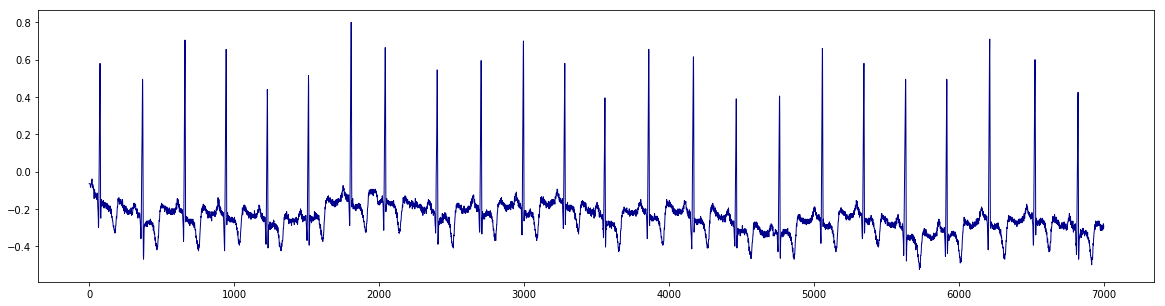

In [198]:
# Loading ECG signal

EcgSignal2 = np.genfromtxt('100_V5.dat')

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(EcgSignal2[0:7000], color='darkblue', linewidth=1)
plt.show()

Signal=EcgSignal2
CzasSygnalu=np.arange(0,np.size(Signal),1)
SignalLengthToDisplay=4000


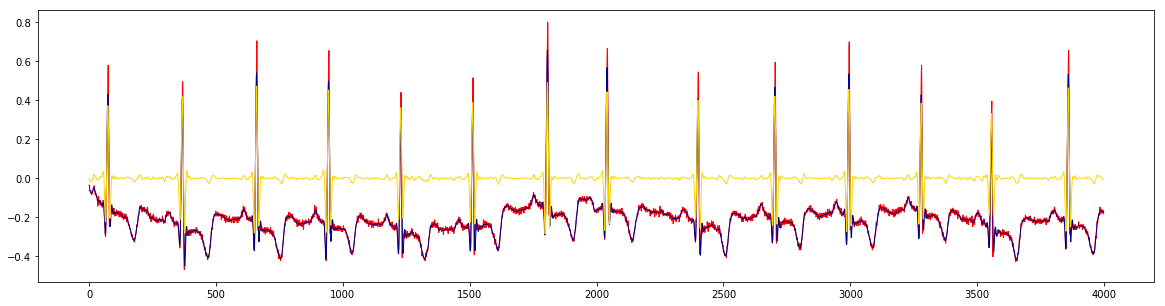

In [199]:
# Signal filtering

WynikFiltracji=filtracja(15,360,1,40,Signal)
WynikFiltracji2=filtracja(5,360,2,40,WynikFiltracji)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(Signal[0:SignalLengthToDisplay], color='red', linewidth=1)
ax.plot(WynikFiltracji[0:SignalLengthToDisplay], color='darkblue', linewidth=1)
ax.plot(WynikFiltracji2[0:SignalLengthToDisplay], color='gold', linewidth=1)
plt.show()

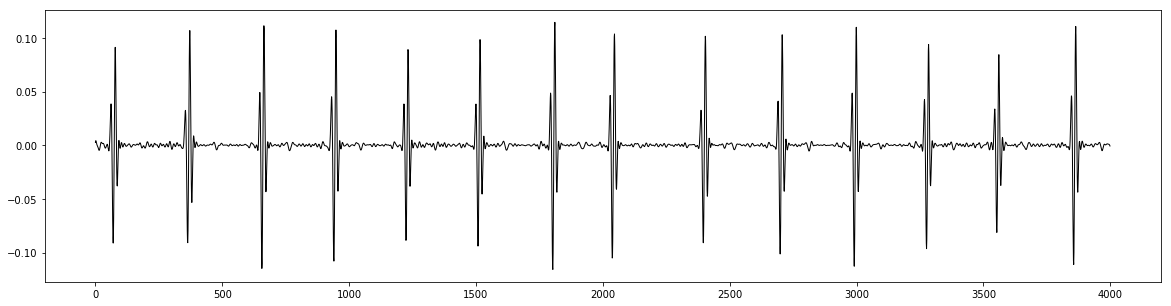

In [200]:
# Signal differentiation

diff = (-2, -1, 1, 2)
diff=[1/8*x for x in diff]

WynikRozniczkowania=np.convolve(WynikFiltracji2,diff,mode='same')

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(WynikRozniczkowania[0:SignalLengthToDisplay], color='black', linewidth=1)
plt.show()

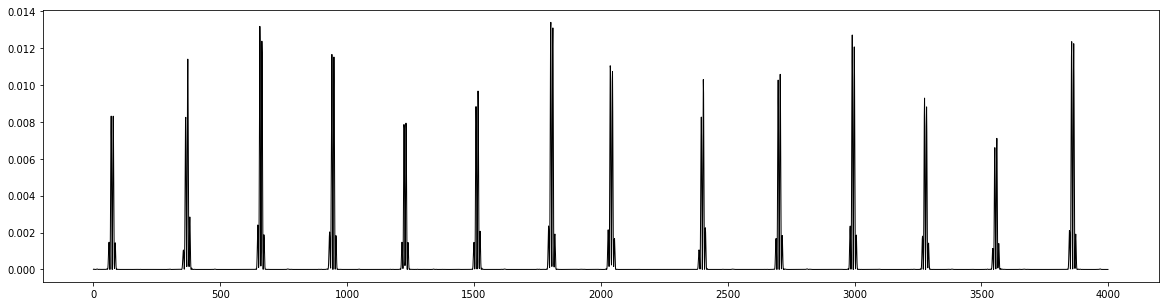

In [201]:
# Signal power

WynikPotegowania=[pow(x,2) for x in WynikRozniczkowania]

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(WynikPotegowania[0:SignalLengthToDisplay], color='black', linewidth=1)
plt.show()

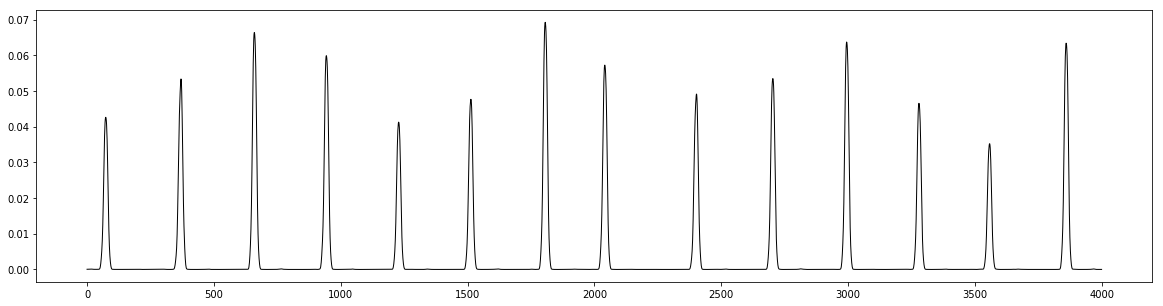

In [202]:
# Signal integration

window2 = signal.blackman(25)
WynikCalkowania=np.convolve(WynikPotegowania,window2,mode='same');

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(WynikCalkowania[0:SignalLengthToDisplay], color='black', linewidth=1)
plt.show()

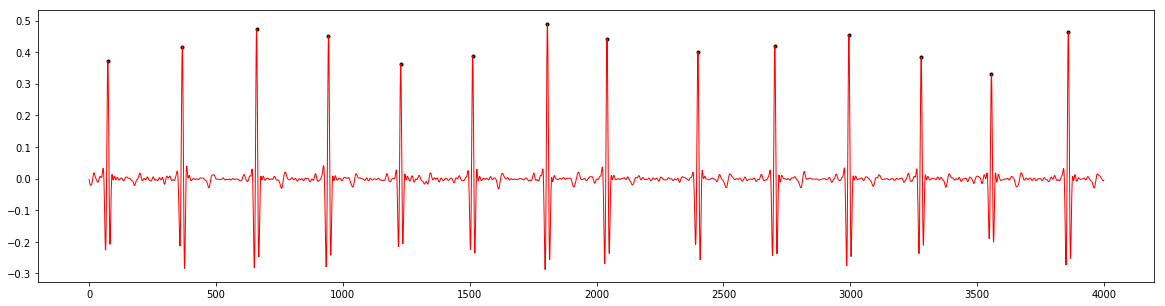

In [251]:
# R-peaks detection

ProgAdaptacyjny=np.sum(WynikCalkowania)/np.size(WynikCalkowania);
PikiMax=[]
CzasMax=[]

for x in range(4,np.size(WynikCalkowania)-4):
    if WynikCalkowania[x] > ProgAdaptacyjny:
        if AmplitudeCheck(x,WynikCalkowania)==1:
            wartoscMax=max(WynikFiltracji2[x-4:x+4])
            indeks=(x-4)+index(WynikFiltracji2[x-4:x+4],wartoscMax)[0]
            PikiMax.insert(len(PikiMax),wartoscMax)
            CzasMax.insert(len(CzasMax),indeks)
                

WhatToDisplay=ToDisplay(CzasMax,SignalLengthToDisplay)
                
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(WynikFiltracji2[0:SignalLengthToDisplay], color='red', linewidth=1)
ax.scatter(CzasMax[0:WhatToDisplay[0]], PikiMax[0:WhatToDisplay[0]], color='black', linewidth=1, marker='.')
plt.show()


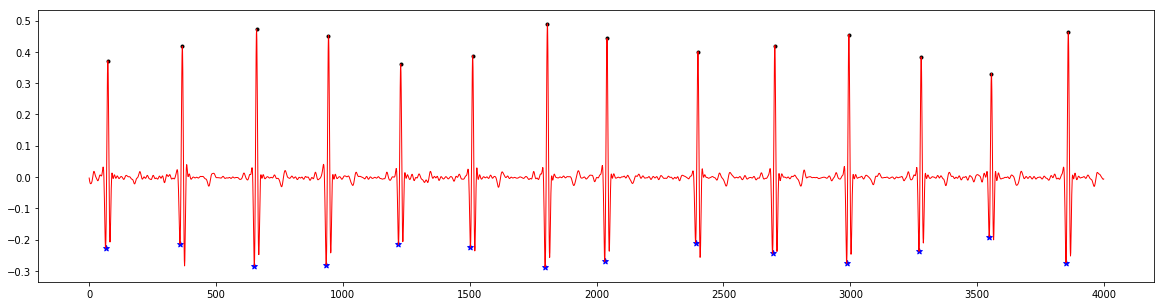

In [252]:
# QRS onset detection

# [onsety, CzasOnsetow]=QRSonset(Signal,CzasMax)
[onsety, CzasOnsetow]=QRSonset(WynikFiltracji2,CzasMax)
WhatToDisplayOnset=ToDisplay(CzasOnsetow,SignalLengthToDisplay)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(WynikFiltracji2[0:SignalLengthToDisplay], color='red', linewidth=1)
ax.scatter(CzasMax[0:WhatToDisplay[0]], PikiMax[0:WhatToDisplay[0]], color='black', linewidth=1, marker='.')
ax.scatter(CzasOnsetow[0:WhatToDisplayOnset[0]], onsety[0:WhatToDisplayOnset[0]], color='blue', linewidth=1, marker='*')
plt.show()

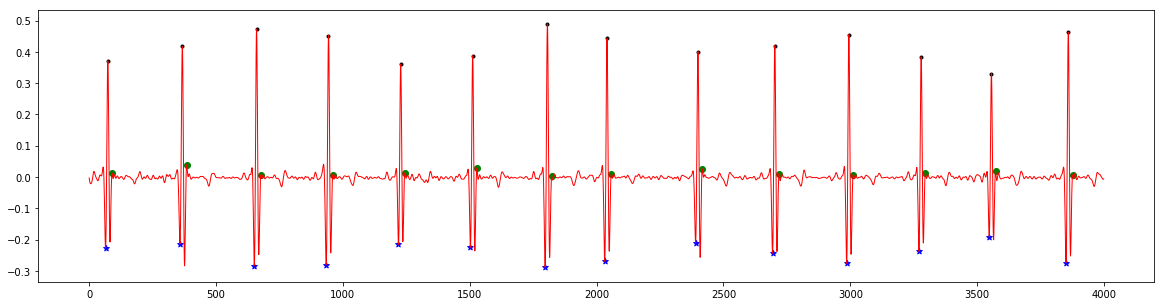

In [205]:
# QRS offset detection

# [offsety,CzasOffsetow]=QRSoffset(Signal,CzasMax)
[offsety,CzasOffsetow]=QRSoffset(WynikFiltracji2,CzasMax)
WhatToDisplayOffset=ToDisplay(CzasOffsetow,SignalLengthToDisplay)
                
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(WynikFiltracji2[0:SignalLengthToDisplay], color='red', linewidth=1)
ax.scatter(CzasMax[0:WhatToDisplay[0]], PikiMax[0:WhatToDisplay[0]], color='black', linewidth=1, marker='.')
ax.scatter(CzasOnsetow[0:WhatToDisplayOnset[0]], onsety[0:WhatToDisplayOnset[0]], color='blue', linewidth=1, marker='*')
ax.scatter(CzasOffsetow[0:WhatToDisplayOffset[0]], offsety[0:WhatToDisplayOffset[0]], color='green', linewidth=1, marker='o')
plt.show()    
        

In [206]:
y=WynikFiltracji2.copy()
RR=[]
#detecting different types of arrhythmia and QRS removal
RR_reentry=[]
RR_interpolation=[]
RR_reset=[]
RR_compensation=[]
RR_other=[]
RR_normal=[]
fs=360
for i in range(len(CzasOnsetow)-1):
    RR.append(CzasOnsetow[i+1]-CzasOnsetow[i])
print(len(RR))
for i in range(1,len(RR)-1):
#     print("~~~{}~~~".format(i))
    RR1=RR[i]-RR[i-1]
    RR2=RR[i+1]-RR[i]

    if (RR2 <= (1.33*RR1) and (RR1+RR2) <= 0.7*fs) or (RR2 <= (0.3*RR1) and RR1 <= fs):
        RR_reentry.append((RR[i],i))
    elif (RR2 <= (1.5*RR1) and (RR1+RR2) <= fs) or (RR2 <= (0.4*RR1) and RR1 <= fs):
        RR_interpolation.append((RR[i],i))
    elif (RR2 <= (1.76*RR1) and (RR1+RR2) <= 1.8*fs) or (RR2 <= (0.65*RR1) and (RR1+RR2) <= 1.8*fs):
        RR_reset.append((RR[i],i))
    elif (RR2 <= (1.35*RR1) and (RR1+RR2) <= 2*fs) or (RR2 <= (0.8*RR1) and RR1 <= 2*fs):
        RR_compensation.append((RR[i],i))
    elif (RR2 > 0.9*fs and RR1 > 0.9*fs):
        RR_other.append((RR[i],i))
    elif RR2>1.2*fs:
        RR_other.append((RR[i],i))
    else:
        RR_normal.append((RR[i],i))


2269


In [207]:
srednia=21
CzasOffsetow.extend([0]*(len(CzasOnsetow)-len(CzasOffsetow)))
for i in range(len(CzasOnsetow)-1):
    if (CzasOffsetow[i]-CzasOnsetow[i]) > 40:
        CzasOffsetow.insert(i,CzasOnsetow[i]+srednia)

2270 2271


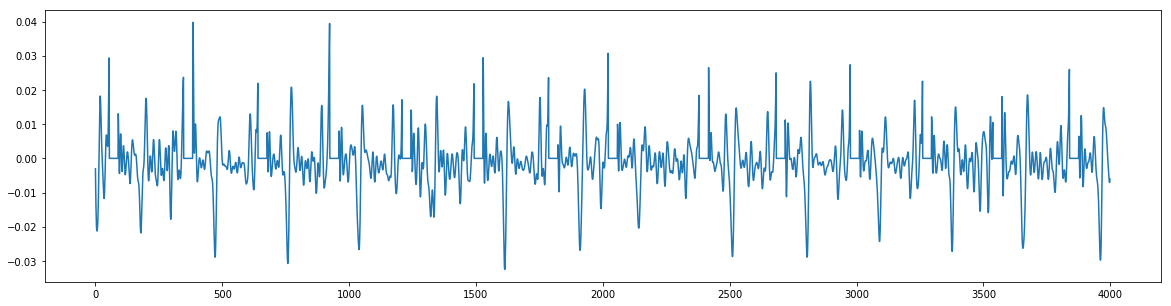

In [208]:
#zerowanie QRS
print(len(CzasOnsetow),len(CzasOffsetow))
for x in range(len(CzasOnsetow)):
    y[CzasOnsetow[x]-10:CzasOffsetow[x]]=0
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(y[0:SignalLengthToDisplay])
plt.show()

In [216]:
#normalized RR intervals average in each category
Mc_reentry=np.sum(RR_reentry)/(len(RR_reentry)*fs)
Mc_interpolation=np.sum(RR_interpolation)/(len(RR_interpolation)*fs)
Mc_reset=np.sum(RR_reset)/(len(RR_reset)*fs)
Mc_compensation=np.sum(RR_compensation)/(len(RR_compensation)*fs)
Mc_other=np.sum(RR_other)/(len(RR_other)*fs)
Mc_normal=np.sum(RR_normal)/(len(RR_normal)*fs)
Mc_all_types=[Mc_reentry,Mc_interpolation,Mc_reset,Mc_compensation,Mc_other,Mc_normal]

D:\Programy\anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [210]:
#W1 - window size of approximately the peak duration of the T wave, W2 - window size of approximately the T wave duration
W1=int(0.07*fs*max(Mc_all_types))
if W1%2==0:
    W1=W1+1
W2=int(0.14*fs*max(Mc_all_types))
if W2%2==0:
    W2=W2+1

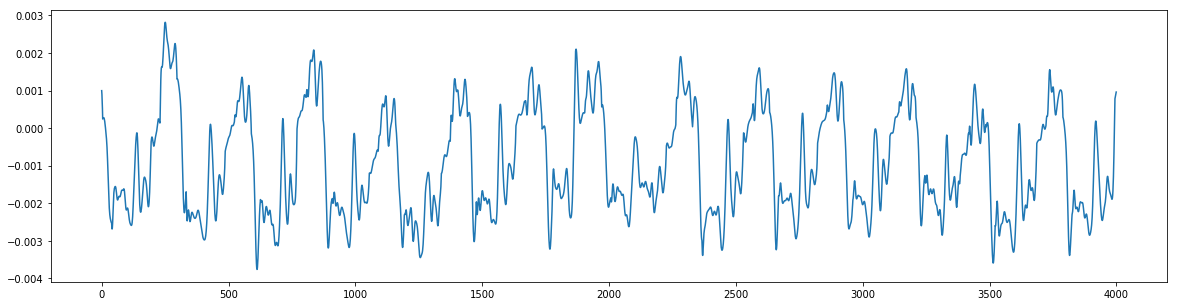

In [244]:
#generating blocks of interest
MApeak=[]
MATwave=[]
for i in range(int((W2-1)/2),int(len(y)-((W2+1)/2))):
    MATwave_i=sum(y[i:i+W2])
    MATwave.append((1/W2)*MATwave_i)
for i in range(int((W1-1)/2),int(len(y)-((W1+1)/2))):
    MApeak_i=sum(y[i:i+W1])
    MApeak.append((1/W1)*MApeak_i)
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(MApeak[0:SignalLengthToDisplay])
plt.show()

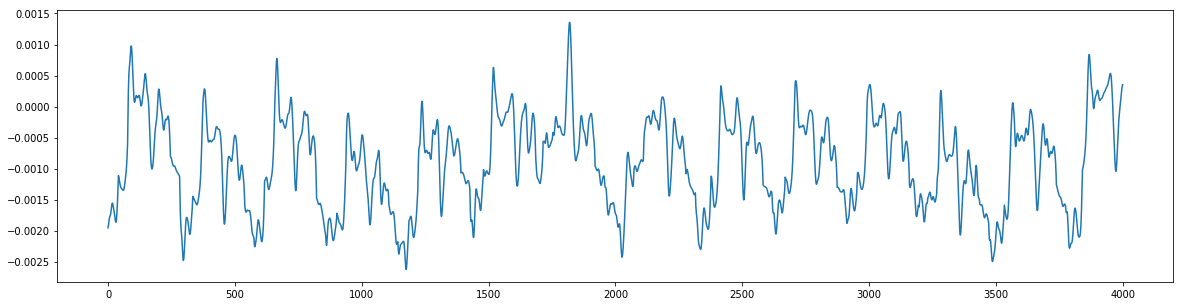

In [245]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(MATwave[0:SignalLengthToDisplay])
plt.show()

In [249]:
#thresholding
RTmin=[]
RTmax=[]
Twave_ind=[]
Twave_amp=[]
for i in range(len(RR)-1):
    RTmin.append(math.floor(0.170*RR[i]))
    RTmax.append(math.ceil(0.8*RR[i]))
for i in range(len(CzasMax)-2):
    Twave_amp.append(np.max(y[CzasMax[i]+RTmin[i]:CzasMax[i]+RTmax[i]]))
    Twave_ind.append(np.argmax(y[CzasMax[i]+RTmin[i]:CzasMax[i]+RTmax[i]])+CzasMax[i])

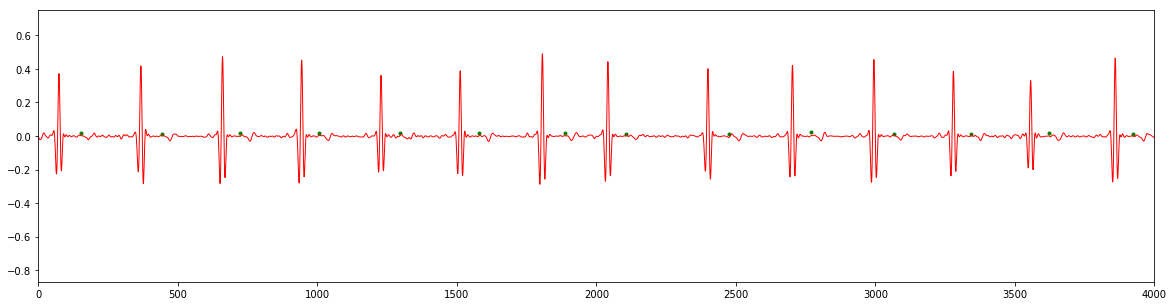

In [250]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(WynikFiltracji2, color='red', linewidth=1)
ax.scatter(Twave_ind, Twave_amp, color='green', linewidth=1, marker='.')
plt.xlim(xmin=0,xmax=4000)
plt.show()   